In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.integrate import solve_ivp
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

In [2]:
# Harmonic Oscillator Dynamics
def harmonic_oscillator(t, y, k, m):
    x, v = y
    dydt = [v, -(k / m) * x]
    return dydt

In [3]:
# Main Workflow
n_samples = 100
output_dir = "oscillator_dataset"
dt = 0.01

In [4]:
# Generate Dataset
def generate_dataset(n_samples, dt, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    dataset = []

    for i in tqdm(range(n_samples), desc="Generating dataset"):
        k = np.random.uniform(1.0, 10.0)  # Spring constant
        m = np.random.uniform(0.5, 5.0)   # Mass
        y0 = np.random.uniform(-2.0, 2.0, 2)  # Initial position and velocity
        t_span = (0, 30)  # Extended time span for 3x movement
        t_eval = np.linspace(t_span[0], t_span[1], int(30 / dt))  # More frames

        sol = solve_ivp(harmonic_oscillator, t_span, y0, t_eval=t_eval, args=(k, m), method='RK45')
        data = sol.y.T  # Positions and velocities over time

        gif_path = os.path.join(output_dir, f"oscillator_{i}.gif")
        generate_gif(data[:, 0], gif_path)

        dataset.append((data, k, m, gif_path))

    return dataset

In [5]:
# Generate GIFs
def generate_gif(positions, save_path):
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-0.5, 0.5)
    line, = ax.plot([], [], 'o-', lw=2)

    def update(frame):
        line.set_data([positions[frame], 0], [0, 0])
        return line,

    ani = FuncAnimation(fig, update, frames=len(positions), blit=True, interval=50)
    ani.save(save_path, fps=20, writer='pillow')
    plt.close(fig)

In [6]:
dataset = generate_dataset(n_samples, dt, output_dir)

Generating dataset: 100%|██████████| 100/100 [2:40:10<00:00, 96.10s/it]  


In [7]:
# Dataset Class
class HarmonicOscillatorDataset(Dataset):
    def __init__(self, dataset, seq_len, pred_len):
        self.dataset = dataset
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, k, m, gif_path = self.dataset[idx]
        positions = data[:, 0]

        input_seq = positions[:self.seq_len]
        target_seq = positions[self.seq_len:self.seq_len + self.pred_len]

        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32), gif_path

In [8]:
seq_len = 270
pred_len = int(0.2 * seq_len) 

In [9]:
# Prepare datasets and dataloaders
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

train_dataset = HarmonicOscillatorDataset(train_data, seq_len, pred_len)
val_dataset = HarmonicOscillatorDataset(val_data, seq_len, pred_len)
test_dataset = HarmonicOscillatorDataset(test_data, seq_len, pred_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
# Define model parameters
input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 2

In [11]:
# Model Definition
class LSTMOscillatorPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, pred_len):
        super(LSTMOscillatorPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.pred_len = pred_len

    def forward(self, x):
        batch_size = x.size(0)
        outputs, _ = self.lstm(x)
        # Predict a sequence of length `pred_len`
        predictions = []
        for _ in range(self.pred_len):
            last_output = outputs[:, -1, :].unsqueeze(1)  # Get the last hidden state
            next_output = self.fc(last_output)
            predictions.append(next_output.squeeze(1))
            outputs = torch.cat([outputs, last_output], dim=1)  # Append prediction to sequence
        return torch.stack(predictions, dim=1)  # Return as sequence

In [12]:
# Training the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # Compare sequences
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, targets, _ in val_loader:
                inputs = inputs.unsqueeze(-1)  # Add feature dimension
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))  # Compare sequences
                val_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

In [13]:
# Generate Prediction GIFs
def generate_prediction_gif(model, test_loader, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    for i, (inputs, targets, gif_path) in enumerate(test_loader):
        with torch.no_grad():
            predictions = model(inputs).squeeze(0).numpy()

        true_positions = targets.numpy()
        input_positions = inputs.squeeze(0).numpy()

        fig, ax = plt.subplots(figsize=(6, 2))
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-0.5, 0.5)
        true_line, = ax.plot([], [], 'o-', lw=2, label='True Motion')
        pred_line, = ax.plot([], [], 'o-', lw=2, linestyle='--', label='Predicted Motion')

        def update(frame):
            if frame < len(input_positions):
                true_line.set_data([input_positions[frame], 0], [0, 0])
            else:
                idx = frame - len(input_positions)
                true_line.set_data([true_positions[idx], 0], [0, 0])
                pred_line.set_data([predictions[idx], 0], [0, 0])
            return true_line, pred_line

        ani = FuncAnimation(fig, update, frames=len(input_positions) + len(true_positions), blit=True, interval=50)
        ani.save(os.path.join(output_dir, f"prediction_{i}.gif"), fps=20, writer='imagemagick')
        plt.close(fig)

In [14]:
# Instantiate the model
model = LSTMOscillatorPredictor(input_dim, hidden_dim, output_dim, num_layers, pred_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 54])) that is different to the input size (torch.Size([32, 54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20:  67%|██████▋   | 2/3 [00:00<00:00,  3.29it/s]C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 54])) that is different to the input size (torch.Size([16, 54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch 1, Train Loss: 1.4155, Val Loss: 1.6669


Epoch 2/20: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Epoch 2, Train Loss: 1.3020, Val Loss: 1.5695


Epoch 3/20: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch 3, Train Loss: 1.1138, Val Loss: 1.4572


Epoch 4/20: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


Epoch 4, Train Loss: 1.1590, Val Loss: 1.3085


Epoch 5/20: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Epoch 5, Train Loss: 1.0518, Val Loss: 1.0960


Epoch 6/20: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Epoch 6, Train Loss: 0.8521, Val Loss: 0.7899


Epoch 7/20: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


Epoch 7, Train Loss: 0.6418, Val Loss: 0.4891


Epoch 8/20: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 8, Train Loss: 0.5457, Val Loss: 0.3982


Epoch 9/20: 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


Epoch 9, Train Loss: 0.4896, Val Loss: 0.2668


Epoch 10/20: 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Epoch 10, Train Loss: 0.4460, Val Loss: 0.2420


Epoch 11/20: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 11, Train Loss: 0.4586, Val Loss: 0.2601


Epoch 12/20: 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


Epoch 12, Train Loss: 0.3790, Val Loss: 0.2919


Epoch 13/20: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch 13, Train Loss: 0.3392, Val Loss: 0.3169


Epoch 14/20: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch 14, Train Loss: 0.3174, Val Loss: 0.3405


Epoch 15/20: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch 15, Train Loss: 0.3180, Val Loss: 0.3473


Epoch 16/20: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Epoch 16, Train Loss: 0.3139, Val Loss: 0.3364


Epoch 17/20: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 17, Train Loss: 0.2992, Val Loss: 0.3358


Epoch 18/20: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch 18, Train Loss: 0.2914, Val Loss: 0.3371


Epoch 19/20: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Epoch 19, Train Loss: 0.2831, Val Loss: 0.3303


Epoch 20/20: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

Epoch 20, Train Loss: 0.2910, Val Loss: 0.3172


In [16]:
generate_prediction_gif(model, test_loader, output_dir="predicted_gifs")

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 270

In [17]:
!pip install pillow

In [18]:
def visualize_harmonic_oscillator_predictions(example, model, pred_len, save_path=None):
    """
    Visualize harmonic oscillator predictions vs. ground truth for the prediction part.

    Args:
        example: A single data point from the dataset (inputs, targets, gif_path).
        model: Trained PyTorch model for predictions.
        pred_len: Expected length of the predicted sequence.
        save_path: Path to save the animation as a GIF (optional).
    """
    model.eval()

    inputs, targets, _ = example
    inputs = inputs.unsqueeze(0).unsqueeze(-1)  # Add batch and feature dimensions
    with torch.no_grad():
        predictions = model(inputs).squeeze(0).squeeze(-1).numpy()

    # Extract true and predicted positions for the prediction phase
    true_positions = targets.numpy()[:pred_len]
    pred_positions = predictions[:pred_len]

    # Debugging: Check the values
    print(f"True Positions: {true_positions}")
    print(f"Predicted Positions: {pred_positions}")

    # Ensure lengths match
    actual_pred_len = min(len(true_positions), len(pred_positions))
    true_positions = true_positions[:actual_pred_len]
    pred_positions = pred_positions[:actual_pred_len]

    # Visualization
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_aspect('equal')

    # Create initial plots
    true_line, = ax.plot([], [], 'o-', lw=2, label='Ground Truth', color='blue')
    pred_line, = ax.plot([], [], 'o--', lw=2, label='Prediction', color='orange')
    ax.legend()

    def update(frame):
        # Update the ground truth and prediction lines
        true_line.set_data([true_positions[frame], 0], [0, 0])
        pred_line.set_data([pred_positions[frame], 0], [0, 0])
        return true_line, pred_line

    ani = FuncAnimation(
        fig, update, frames=actual_pred_len, blit=True, interval=50
    )

    if save_path:
        ani.save(save_path, fps=20, writer='pillow')
        print(f"Animation saved at {save_path}")
    else:
        plt.show()

True Positions: [1.681392  1.6973087 1.7130045 1.7284772 1.7437248 1.758745  1.7735355
 1.7880944 1.8024197 1.8165091 1.830361  1.8439733 1.8573439 1.8704714
 1.8833536 1.8959888 1.9083755 1.9205117 1.932396  1.9440267 1.9554023
 1.966521  1.9773816 1.9879826 1.9983226 2.0084002 2.018214  2.0277627
 2.0370452 2.0460603 2.054807  2.0632834 2.0714893 2.0794234 2.0870845
 2.0944717 2.1015842 2.108421  2.1149814 2.1212645 2.1272693 2.1329956
 2.1384423 2.143609  2.148495  2.1530995 2.1574225 2.1614633 2.1652212
 2.168696  2.1718874 2.1747952 2.1774187 2.179758 ]
Predicted Positions: [1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042
 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042
 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042
 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042
 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042
 1.1603042 1.1603042 1.1603042 1.1603042 1.1603042 1.160304

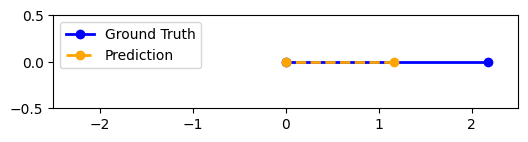

In [19]:
# Visualize predictions for one example
example = test_dataset[0]
visualize_harmonic_oscillator_predictions(
    example, model, pred_len, save_path="harmonic_oscillator_prediction_vs_ground_truth.gif"
)